<a href="https://colab.research.google.com/github/surajsrivathsa/ovgu_deeplearning/blob/master/Assignment_10_Adversarial_Examples_%26_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Deep Learning programming task

**Assignment 10:** Adverserial Examples and Training

**Team members:**
1. Sanjeeth Busnur Indushekar: 224133 : sanjeeth.busnur@st.ovgu.de
2. Aditya Dey : 230580 : aditya.dey@st.ovgu.de
3. Suraj Shashidhar: 230052 : suraj.shashidhar@st.ovgu.de

**Tasks to be done**

1) **Creating Adverserial examples**

**White box attacks: Attack models by using its parameters or learned knowledge**

a) **Untargeted Attack**: We don't apply any distinction on which type of input we are trying to morph and also what it should be morphed into. For example: 3 could be morphed to 0 and another 3 could be morphed to 1, there is no targeting. Hence we simply device methods to increase loss through out inputs rather than picking a distinct input/output mapping.

- Train the simple mlp based model on MNSIT(because MNSIT is simple and has only one channel)

- After training, Take a batch of inputs that were used in training(preferably the batch that has all the class labels).

- Run it through a customized gradient tape, where you calculate loss between input image vs output prediction and not between output prediction vs actual label. This is similar to whats done in neural style transfer where we update input image pixel values based on gradients.

- Instead of reducing the loss from input we would be somewhat increasing it by adding the weighted computed gradient to input image. If we subtract the gradients we would not be targeting rather than making input much better for classifictaion. We also weigh the gradients by learning rate so that the applied loss doesn't change the image too much visually

- We can have different types of weighing schemes instead of multiplying with a learning rate. First one is normalize each gradienbt of the pixel to a unit vector or some vector with constant magnitude. We can also do a gradient sign method. Any other schemes are alo welcome?

- Normalize the image pixels values again to be inside [0,1] range.

- Run it through the prediction to see the wrongly classified images.

b) **Targeted attack**: Make the network break for specific type of inputs-output mapping. for example make all inputs to be classified as 1 or 7.

Black box attacks: Attack the model without knowing its parameters or gradients
Check reference 6

- Do adversarial attacks actually pose a threat to DL-systems in the real-world?

- Introspection with Activation maximization

2) Adverserial Training

- Integrate adverserial examples into training loop. First run a batch of input and compute loss(predicted vs actual class). Create adverserial examples for the same batch using loss(predicted label vs input image). Do a normal backprop using both the losses or only adverseril loss through ther network.

- Test the network with similar but new adverserial examples and see its performance improves.

- See if the untargeted adverserial training is robust against the targeted training examples or some other method such as multiple gradient steps.

**References:**

1) **Overview blog**: https://medium.com/@ml.at.berkeley/tricking-neural-networks-create-your-own-adversarial-examples-a61eb7620fd8

2) **Overview Blog**: https://openai.com/blog/adversarial-example-research/#:~:text=Machine%20Learning-,with%20Adversarial,like%20optical%20illusions%20for%20machines.

3) **Book**: https://christophm.github.io/interpretable-ml-book/

4) **Library for adverserial attacks**: https://github.com/tensorflow/cleverhans

5) **Untargeted attack Gradient sign**: https://www.tensorflow.org/tutorials/generative/adversarial_fgsm

6) **Blackbox attack**: https://christophm.github.io/interpretable-ml-book/adversarial.html

7) **Activation maximization**: https://distill.pub/2017/feature-visualization/

8) **Does adverserial training hurts the original data?**: https://arxiv.org/pdf/1906.06032.pdf

9) **Explaining and harnessing adverserial examples:** https://arxiv.org/abs/1412.6572

10) **Adversarial Examples: Opportunities and Challenges:** https://arxiv.org/abs/1809.04790



In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from tensorflow.keras.layers import Conv2D,MaxPooling2D,AveragePooling2D,BatchNormalization,Activation,Add,Flatten,Dense,Input,ZeroPadding2D
from tensorflow.keras.models import Model
import keras.backend as K

Using TensorFlow backend.


In [ ]:
from tensorflow.keras.initializers import glorot_uniform

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import os

In [ ]:
os.chdir('/content/drive/My Drive/Colab Notebooks/Assignment-9')

In [ ]:
import zipfile

In [ ]:
local_zip = "/content/drive/My Drive/Colab Notebooks/Assignment-9/cifar_attempts.zip"
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

In [ ]:
def identity_block(X, f, filters, stage, block):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    F1, F2, F3 = filters
    
    X_shortcut = X
    
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'same', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    X = Add()([X_shortcut,X])
    X = Activation('relu')(X)
    
    return X

In [ ]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(F2, (f, f), strides = (1,1), padding='same',name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(F3, (1, 1), strides = (1,1), padding='valid',name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), padding='valid',name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    X = Add()([X_shortcut,X])
    X = Activation('relu')(X)
    
    return X

In [ ]:
def ResNet50(input_shape = (32, 32, 3), classes = 10):
    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7,7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    X = convolutional_block(X, f = 3, filters = [128,128,512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128,128,512], stage=3, block='b')
    X = identity_block(X, 3, [128,128,512], stage=3, block='c')
    X = identity_block(X, 3, [128,128,512], stage=3, block='d')

    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # X = AveragePooling2D((1,1),name='avg_pool')(X)
    
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)

    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

# data1.npz

In [ ]:
model = ResNet50(input_shape = (32, 32, 3), classes = 10)

In [ ]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 16, 16, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
data_1 = np.load("data1.npz")

In [ ]:
data_1.files

['train_imgs', 'train_lbls', 'val_imgs', 'val_lbls', 'test_imgs', 'test_lbls']

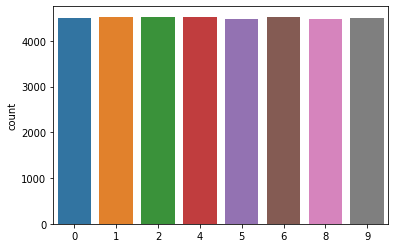

In [ ]:
sns.countplot(data_1['train_lbls'])

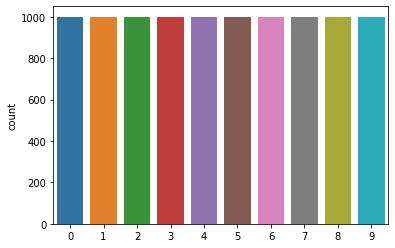

In [ ]:
sns.countplot(data_1['test_lbls'])

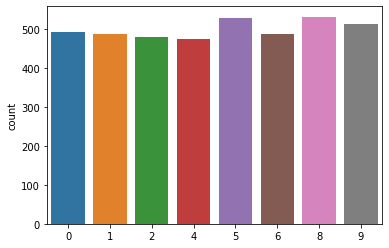

In [ ]:
sns.countplot(data_1['val_lbls'])

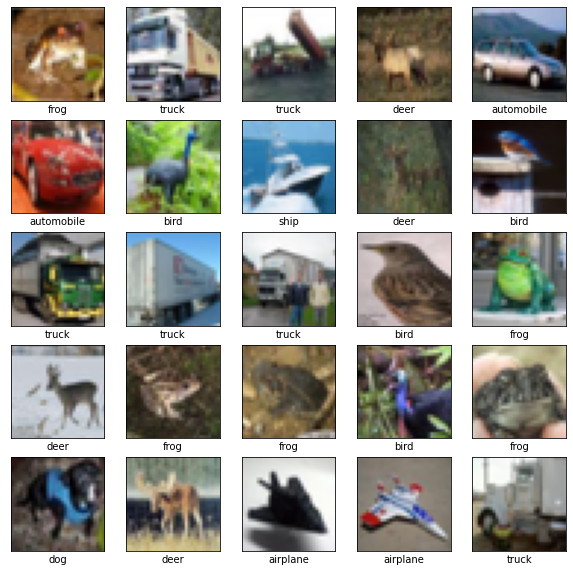

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(data_1['train_imgs'][i], cmap=plt.cm.binary)
  plt.xlabel(class_names[data_1['train_lbls'][i]])
plt.show()

In [ ]:
X_train = data_1['train_imgs']/255.
X_test = data_1['test_imgs']/255.
X_validate = data_1['val_imgs']/255.

Y_train = tf.one_hot(data_1['train_lbls'], 10)
Y_test = tf.one_hot(data_1['test_lbls'], 10)
Y_validate = tf.one_hot(data_1['val_lbls'], 10)

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("number of validation examples = " + str(X_validate.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_validate shape: " + str(X_validate.shape))
print ("Y_validate shape: " + str(Y_validate.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 36004
number of test examples = 10000
number of validation examples = 3996
X_train shape: (36004, 32, 32, 3)
Y_train shape: (36004, 10)
X_validate shape: (3996, 32, 32, 3)
Y_validate shape: (3996, 10)
X_test shape: (10000, 32, 32, 3)
Y_test shape: (10000, 10)


In [ ]:
model.fit(X_train, Y_train, epochs = 10, batch_size = 128,validation_data=(X_validate,Y_validate),validation_batch_size=32)

Epoch 1/10
282/282 [==============================] - 16s 58ms/step - loss: 1.7437 - accuracy: 0.4080 - val_loss: 3.1708 - val_accuracy: 0.1189
Epoch 2/10
282/282 [==============================] - 15s 54ms/step - loss: 1.4026 - accuracy: 0.5284 - val_loss: 2.3007 - val_accuracy: 0.2272
Epoch 3/10
282/282 [==============================] - 15s 54ms/step - loss: 1.2136 - accuracy: 0.5852 - val_loss: 1.9081 - val_accuracy: 0.2683
Epoch 4/10
282/282 [==============================] - 15s 55ms/step - loss: 1.2445 - accuracy: 0.5889 - val_loss: 3.7837 - val_accuracy: 0.1341
Epoch 5/10
282/282 [==============================] - 15s 54ms/step - loss: 1.3438 - accuracy: 0.5647 - val_loss: 4.5089 - val_accuracy: 0.1221
Epoch 6/10
282/282 [==============================] - 15s 54ms/step - loss: 1.3881 - accuracy: 0.5464 - val_loss: 2.7390 - val_accuracy: 0.2045
Epoch 7/10
282/282 [==============================] - 15s 54ms/step - loss: 1.2487 - accuracy: 0.5594 - val_loss: 2.3495 - val_accuracy:

In [ ]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

313/313 [==============================] - 3s 11ms/step - loss: 83.8415 - accuracy: 0.1860
Loss = 83.84146881103516
Test Accuracy = 0.1860000044107437


# data2.npz

In [ ]:
data_2 = np.load("data2.npz")

In [ ]:
data_2.files

['train_imgs', 'train_lbls', 'val_imgs', 'val_lbls', 'test_imgs', 'test_lbls']

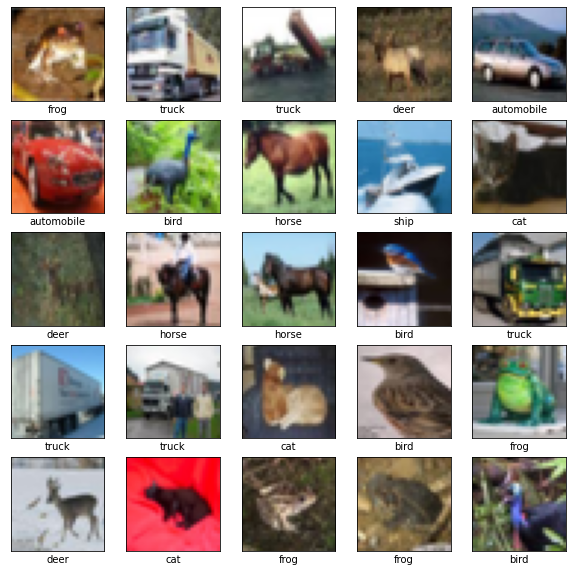

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(data_2['train_imgs'][i], cmap=plt.cm.binary)
  plt.xlabel(class_names[data_2['train_lbls'][i]])
plt.show()

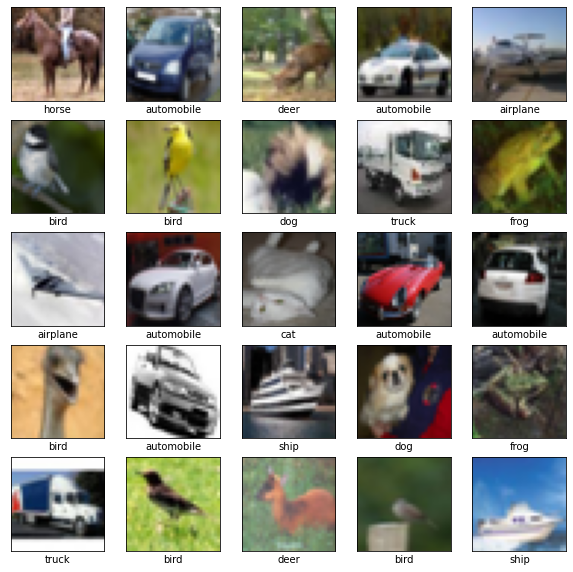

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(data_2['val_imgs'][i], cmap=plt.cm.binary)
  plt.xlabel(class_names[data_2['val_lbls'][i]])
plt.show()

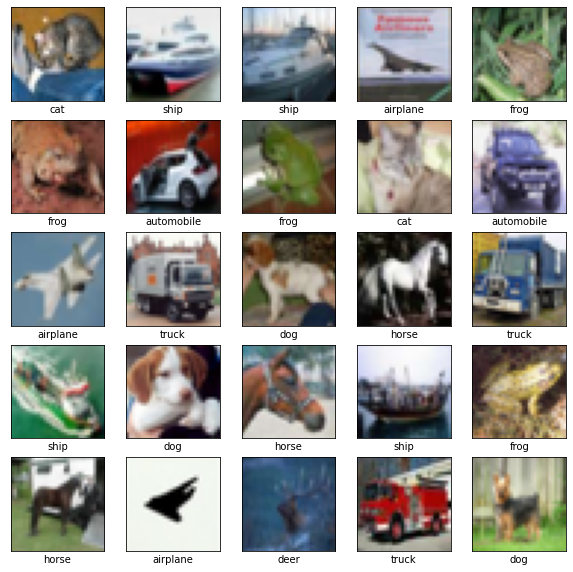

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(data_2['test_imgs'][i], cmap=plt.cm.binary)
  plt.xlabel(class_names[data_2['test_lbls'][i]])
plt.show()

In [ ]:
X_train_2 = data_2['train_imgs']/255.
X_test_2 = data_2['test_imgs']/255.
X_validate_2 = data_2['val_imgs']/255.

Y_train_2 = tf.one_hot(data_2['train_lbls'], 10)
Y_test_2 = tf.one_hot(data_2['test_lbls'], 10)
Y_validate_2 = tf.one_hot(data_2['val_lbls'], 10)

print ("number of training examples = " + str(X_train_2.shape[0]))
print ("number of test examples = " + str(X_test_2.shape[0]))
print ("number of validation examples = " + str(X_validate_2.shape[0]))
print ("X_train_2 shape: " + str(X_train_2.shape))
print ("Y_train_2 shape: " + str(Y_train_2.shape))
print ("X_test_2 shape: " + str(X_test_2.shape))
print ("Y_test_2 shape: " + str(Y_test_2.shape))
print ("X_validate_2 shape: " + str(X_validate_2.shape))
print ("Y_validate_2 shape: " + str(Y_validate_2.shape))

number of training examples = 50000
number of test examples = 10000
number of validation examples = 5000
X_train_2 shape: (50000, 32, 32, 3)
Y_train_2 shape: (50000, 10)
X_test_2 shape: (10000, 32, 32, 3)
Y_test_2 shape: (10000, 10)
X_validate_2 shape: (5000, 32, 32, 3)
Y_validate_2 shape: (5000, 10)


In [ ]:
model_2 = ResNet50(input_shape = (32, 32, 3), classes = 10)

In [ ]:
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_2.fit(X_train_2, Y_train_2, epochs = 10, batch_size = 128,validation_data = (X_validate_2,Y_validate_2),validation_batch_size=32)

Epoch 1/10
391/391 [==============================] - 22s 57ms/step - loss: 1.9568 - accuracy: 0.3618 - val_loss: 3.0107 - val_accuracy: 0.0998
Epoch 2/10
391/391 [==============================] - 21s 54ms/step - loss: 1.7925 - accuracy: 0.4050 - val_loss: 535.9664 - val_accuracy: 0.1064
Epoch 3/10
391/391 [==============================] - 21s 53ms/step - loss: 1.6353 - accuracy: 0.4415 - val_loss: 2.2125 - val_accuracy: 0.2568
Epoch 4/10
391/391 [==============================] - 21s 54ms/step - loss: 1.4862 - accuracy: 0.5039 - val_loss: 1.8358 - val_accuracy: 0.3058
Epoch 5/10
391/391 [==============================] - 21s 53ms/step - loss: 1.6030 - accuracy: 0.5042 - val_loss: 16614.6426 - val_accuracy: 0.0958
Epoch 6/10
391/391 [==============================] - 21s 54ms/step - loss: 1.4702 - accuracy: 0.5109 - val_loss: 1.8703 - val_accuracy: 0.3524
Epoch 7/10
391/391 [==============================] - 21s 54ms/step - loss: 1.2976 - accuracy: 0.5671 - val_loss: 2.5685 - val_acc

In [ ]:
preds = model_2.evaluate(X_test_2, Y_test_2)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

313/313 [==============================] - 3s 11ms/step - loss: 2.4777 - accuracy: 0.2947
Loss = 2.4776556491851807
Test Accuracy = 0.2946999967098236


# data3.npz

In [ ]:
data_3 = np.load("data3.npz")

In [ ]:
data_3.files

['train_imgs', 'train_lbls', 'val_imgs', 'val_lbls', 'test_imgs', 'test_lbls']

In [ ]:
X_train_3 = data_3['train_imgs']/255.
X_test_3 = data_3['test_imgs']/255.
X_validate_3 = data_3['val_imgs']/255.

Y_train_3 = tf.one_hot(data_3['train_lbls'], 10)
Y_test_3 = tf.one_hot(data_3['test_lbls'], 10)
Y_validate_3 = tf.one_hot(data_3['val_lbls'], 10)

print ("number of training examples = " + str(X_train_3.shape[0]))
print ("number of test examples = " + str(X_test_3.shape[0]))
print ("number of validation examples = " + str(X_validate_3.shape[0]))
print ("X_train_3 shape: " + str(X_train_3.shape))
print ("Y_train_3 shape: " + str(Y_train_3.shape))
print ("X_test_3 shape: " + str(X_test_3.shape))
print ("Y_test_3 shape: " + str(Y_test_3.shape))
print ("X_validate_3 shape: " + str(X_validate_3.shape))
print ("Y_validate_3 shape: " + str(Y_validate_3.shape))

number of training examples = 45000
number of test examples = 10000
number of validation examples = 5000
X_train_3 shape: (45000, 32, 32, 3)
Y_train_3 shape: (45000, 10)
X_test_3 shape: (10000, 32, 32, 3)
Y_test_3 shape: (10000, 10)
X_validate_3 shape: (5000, 32, 32, 3)
Y_validate_3 shape: (5000, 10)


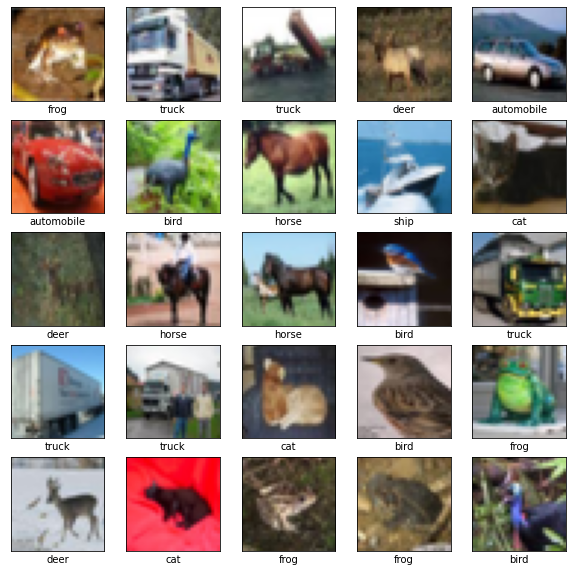

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(data_3['train_imgs'][i], cmap=plt.cm.binary)
  plt.xlabel(class_names[data_3['train_lbls'][i]])
plt.show()

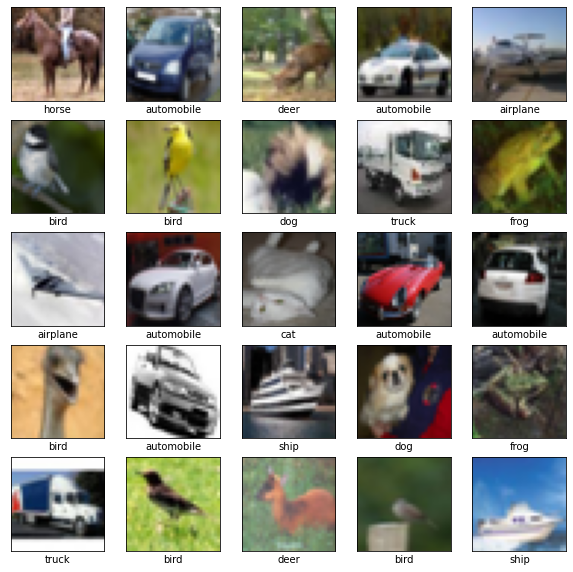

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(data_3['val_imgs'][i], cmap=plt.cm.binary)
  plt.xlabel(class_names[data_3['val_lbls'][i]])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

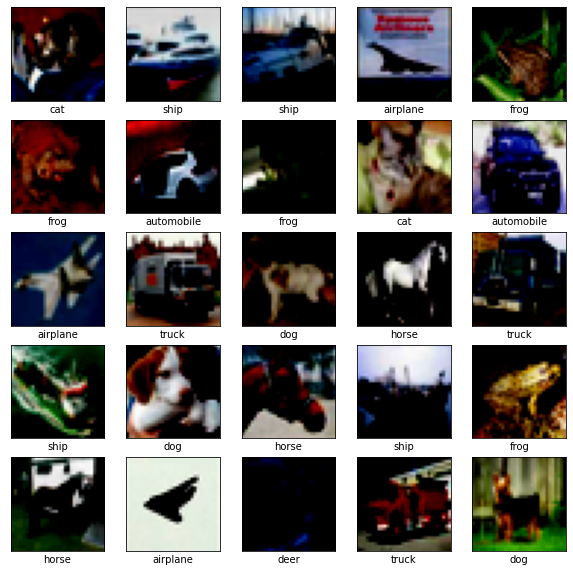

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(data_3['test_imgs'][i], cmap=plt.cm.binary)
  plt.xlabel(class_names[data_2['test_lbls'][i]])
plt.show()

In [ ]:
model_3 = ResNet50(input_shape = (32, 32, 3), classes = 10)

In [ ]:
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_3.fit(X_train_3, Y_train_3, epochs = 10, batch_size = 128,validation_data = (X_validate_3,Y_validate_3),validation_batch_size=32)

Epoch 1/10
352/352 [==============================] - 20s 57ms/step - loss: 1.9979 - accuracy: 0.3480 - val_loss: 2.5732 - val_accuracy: 0.1220
Epoch 2/10
352/352 [==============================] - 19s 54ms/step - loss: 1.7784 - accuracy: 0.4311 - val_loss: 3433.1309 - val_accuracy: 0.0970
Epoch 3/10
352/352 [==============================] - 19s 54ms/step - loss: 1.8088 - accuracy: 0.4145 - val_loss: 14.3874 - val_accuracy: 0.1154
Epoch 4/10
352/352 [==============================] - 19s 54ms/step - loss: 1.7340 - accuracy: 0.4430 - val_loss: 3.8724 - val_accuracy: 0.1316
Epoch 5/10
352/352 [==============================] - 19s 54ms/step - loss: 1.5069 - accuracy: 0.4959 - val_loss: 96.2693 - val_accuracy: 0.1344
Epoch 6/10
352/352 [==============================] - 19s 54ms/step - loss: 1.4148 - accuracy: 0.5288 - val_loss: 7.5880 - val_accuracy: 0.0582
Epoch 7/10
352/352 [==============================] - 19s 54ms/step - loss: 1.3942 - accuracy: 0.5505 - val_loss: 5.1502 - val_accu

In [ ]:
preds = model_3.evaluate(X_test_3, Y_test_3)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

313/313 [==============================] - 3s 11ms/step - loss: 2.3747 - accuracy: 0.1155
Loss = 2.3747432231903076
Test Accuracy = 0.11550000309944153


# data4.npz

In [ ]:
data_4 = np.load("data4.npz")

In [ ]:
data_4.files

['train_imgs', 'train_lbls', 'val_imgs', 'val_lbls', 'test_imgs', 'test_lbls']

In [ ]:
X_train_4 = data_4['train_imgs']/255.
X_test_4 = data_4['test_imgs']/255.
X_validate_4 = data_4['val_imgs']/255.

Y_train_4 = tf.one_hot(data_4['train_lbls'], 10)
Y_test_4 = tf.one_hot(data_4['test_lbls'], 10)
Y_validate_4 = tf.one_hot(data_4['val_lbls'], 10)

print ("number of training examples = " + str(X_train_4.shape[0]))
print ("number of test examples = " + str(X_test_4.shape[0]))
print ("number of validation examples = " + str(X_validate_4.shape[0]))
print ("X_train_4 shape: " + str(X_train_4.shape))
print ("Y_train_4 shape: " + str(Y_train_4.shape))
print ("X_test_4 shape: " + str(X_test_4.shape))
print ("Y_test_4 shape: " + str(Y_test_4.shape))
print ("X_validate_4 shape: " + str(X_validate_4.shape))
print ("Y_validate_4 shape: " + str(Y_validate_4.shape))

number of training examples = 45000
number of test examples = 10000
number of validation examples = 5000
X_train_4 shape: (45000, 32, 32, 3)
Y_train_4 shape: (45000, 10)
X_test_4 shape: (10000, 32, 32, 3)
Y_test_4 shape: (10000, 10)
X_validate_4 shape: (5000, 32, 32, 3)
Y_validate_4 shape: (5000, 10)


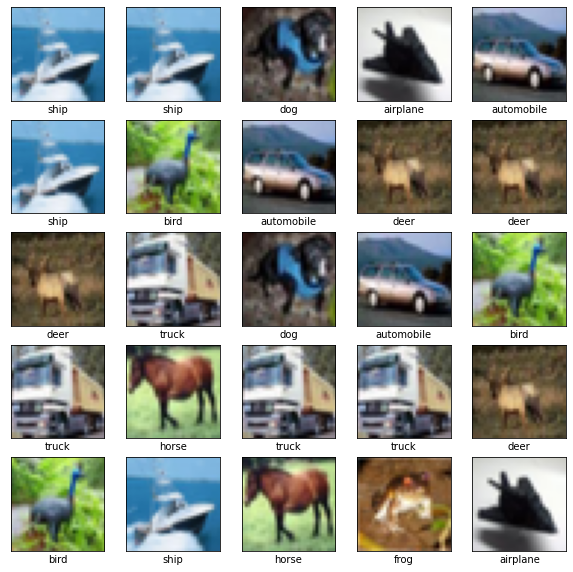

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(data_4['train_imgs'][i], cmap=plt.cm.binary)
  plt.xlabel(class_names[data_4['train_lbls'][i]])
plt.show()

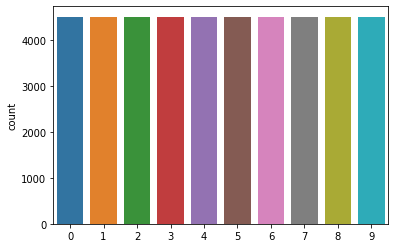

In [ ]:
sns.countplot(data_4['train_lbls'])

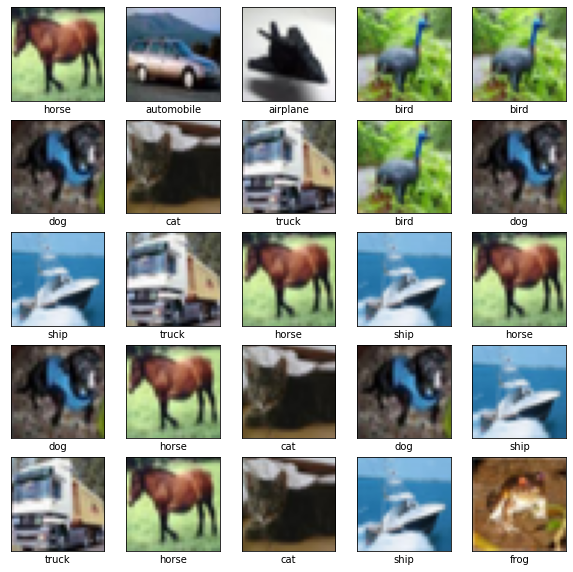

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(data_4['val_imgs'][i], cmap=plt.cm.binary)
  plt.xlabel(class_names[data_4['val_lbls'][i]])
plt.show()

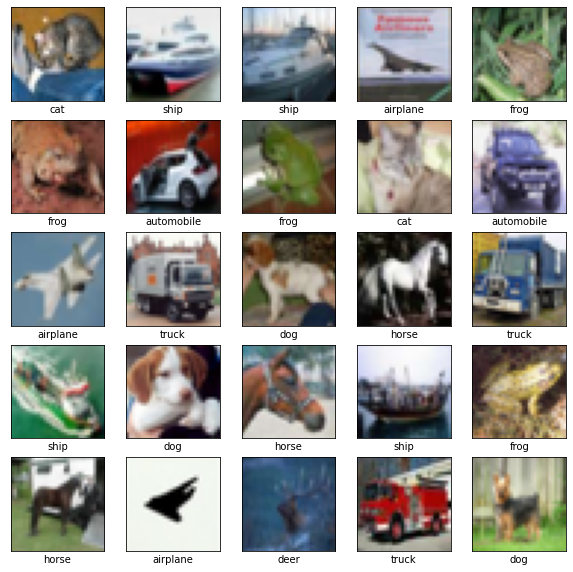

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(data_4['test_imgs'][i], cmap=plt.cm.binary)
  plt.xlabel(class_names[data_4['test_lbls'][i]])
plt.show()

In [ ]:
model_4 = ResNet50(input_shape = (32, 32, 3), classes = 10)

In [ ]:
model_4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_4.fit(X_train_4, Y_train_4, epochs = 10, batch_size = 128,validation_data = (X_validate_4,Y_validate_4),validation_batch_size=32)

Epoch 1/10
352/352 [==============================] - 20s 56ms/step - loss: 0.0711 - accuracy: 0.9873 - val_loss: 16.8934 - val_accuracy: 0.1000
Epoch 2/10
352/352 [==============================] - 19s 54ms/step - loss: 2.7740e-06 - accuracy: 1.0000 - val_loss: 9.9846 - val_accuracy: 0.2000
Epoch 3/10
352/352 [==============================] - 19s 54ms/step - loss: 1.0435e-06 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
352/352 [==============================] - 19s 54ms/step - loss: 9.6440e-08 - accuracy: 1.0000 - val_loss: 1.1921e-08 - val_accuracy: 1.0000
Epoch 5/10
352/352 [==============================] - 19s 55ms/step - loss: 4.2325e-07 - accuracy: 1.0000 - val_loss: 1.1921e-08 - val_accuracy: 1.0000
Epoch 6/10
352/352 [==============================] - 19s 54ms/step - loss: 1.3586e-07 - accuracy: 1.0000 - val_loss: 1.1921e-08 - val_accuracy: 1.0000
Epoch 7/10
352/352 [==============================] - 19s 54ms/step - loss: 0.1637 - accuracy: 0.97

In [ ]:
preds = model_4.evaluate(X_test_4, Y_test_4)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

313/313 [==============================] - 3s 11ms/step - loss: 24604.2695 - accuracy: 0.1000
Loss = 24604.26953125
Test Accuracy = 0.10000000149011612
